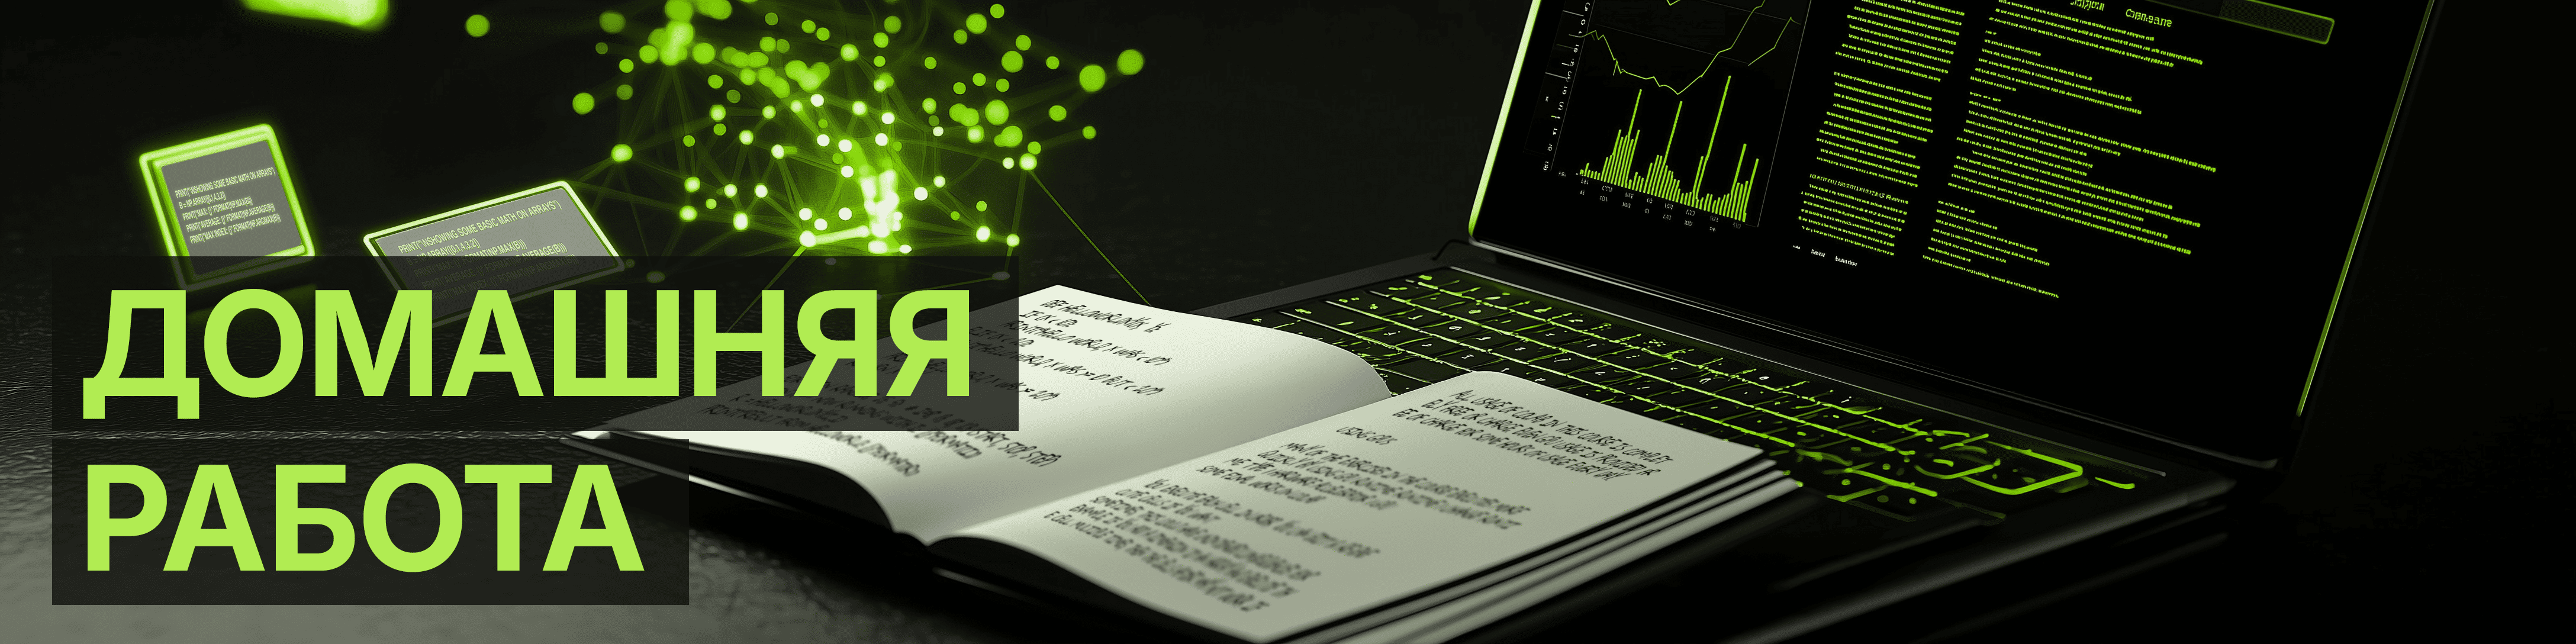

**Навигация по уроку**
1. [Обучение с подкреплением. Основы](https://colab.research.google.com/drive/1Jj_fjuvjcOPzibifkFaVRgfXKO6ASafi)
2. [OpenAI Gym. Простейшие алгоритмы обучения](https://colab.research.google.com/drive/1KvKL7ySnZOBuGFUn8m1QUbQTH5Y00DHf)
3. Домашняя работа

В домашней работе вам необходимо обучить модель играть в игры Atari.
Для этого необходимо установить библиотеки:

In [ ]:
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

Для игр Atari лучше использовать форк gymnasium, он более стабильный и нет проблем с зависимостями, для работы достаточно зарегистрировать окружение:

In [ ]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

В качестве игры выберите игру pac-man или любую другую из набора Atari, например, из этого [списка](https://www.gymlibrary.dev/environments/atari/index.html).

Как говорил Генри Форд: "Вы можете выбрать любой цвет для машины, только если он будет черным!" Также и в домашней работе, вы можете выбрать любую игру, только если она имеет более 4-х элементов управления.

Создание окружения для Pac-Man:

In [ ]:
env = gym.make("ALE/MsPacman-v5")

В домашней работе вам необходимо выполнить одно из трёх заданий на выбор:

**Задание 1. На 3 балла:**

1. Используя Gym Atari, выберите любую игру с более чем 4-мя действиями.
2. Обучите игру на стратегиях случайного поиска и восхождения на вершину.

**Задание 2. На 4 балла:**

1. Используя Gym Atari, выберите любую игру с более чем 4-мя действиями.
2. Обучите игру на стратегиях случайного поиска и восхождения на вершину.
3. Создайте видео с наибольшим вознаграждением и вставьте его в колаб.
  

**Задание 3. На 5 балла:**

1. Используя Gym Atari, выберите любую игру с более чем 4-мя действиями.
2. Обучите игру на стратегии градиента стратегии (градиентной политики).
3. Создайте видео из нескольких игровых эпизодов, в котором модель достигла максимального вознаграждения.
4. Попробуйте по видео объяснить почему алгоритм градиента стратегии плохо подходит для данной задачи. Результат вознаграждения будет ХУЖЕ случайного.
5. Задача выполняется самостоятельно без помощи куратора!

# Запускаем игру

In [1]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install pyvirtualdisplay moviepy > /dev/null 2>&1
!pip install --upgrade pyvirtualdisplay pygame ipykernel > /dev/null 2>&1
!pip install "gymnasium[atari]"
!pip install autorom[accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=autorom_accept_rom_license-0.6.1-py3-none-any.whl size=446709 sha256=c3363a45a97c03b1b5387b2c9ce8ffc5e596da5129319707293e34e187c37c0a
  Stored in directory: /root/.cache/pip/wheels/99/f1/ff/c6966c034a8259164bdc9deb4d1ea839f119474638100e6645
Successfully built AutoROM.accept-rom-license


In [2]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from gymnasium.wrappers import RecordVideo
import base64
from IPython.display import HTML
import torch
import torch.nn as nn
import os
import cv2
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Настраиваем виртуальный дисплей
from pyvirtualdisplay import Display
display = Display(visible=0, size=(800, 600))
display.start()

In [5]:
# выбираем игру
env = gym.make("ALE/Galaxian-v5", obs_type="grayscale")
env.reset(seed=42)

n_state = env.observation_space.shape
n_action = env.action_space.n
print("Размерность пространства игры: ", n_state)
print("Размерность действий в игре: ", n_action)

Размерность пространства игры:  (210, 160)
Размерность действий в игре:  6


## Описание игры

### Action Space
Доступно 6 действий:


Value   |   Meaning

    0   |   NOOP
    1   |   FIRE
    2   |   RIGHT
    3   |   LEFT
    4   |   RIGHTFIRE
    5   |   LEFTFIRE

### Observation Space

obs_type="grayscale" создает поле игры размером (210, 160) в оттенках серого, что упрощает в нашем случае использование матрицы весов, по сравнению с rgb рендером

### Rewards

Очки начисляются за уничтожение кораблей. Корабли на задних линиях имеют более высокую награду.

Так же добавил штраф за нахождение агента в одной области длительное время, чтобы он не сидел в углу. Реализция приведена далее, после тестовых запусков.

In [6]:
# Запускаем один эпизод
for step in range(1000):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print(f"Эпизод завершен на шаге {step}")
        break

env.close()

Эпизод завершен на шаге 404


In [7]:
# Создаем среду с записью видео
VIDEO_DIR = "video_test"
os.makedirs(VIDEO_DIR, exist_ok=True)
env_rec = gym.make("ALE/Galaxian-v5", obs_type="grayscale", render_mode="rgb_array")
env_rec = RecordVideo(env_rec, VIDEO_DIR, name_prefix="Gal_test", episode_trigger=lambda x: True)

In [8]:
# Запускаем один эпизод
observation, info = env_rec.reset(seed=42)
total_reward = 0.0
for step in range(1000):
    action = env_rec.action_space.sample()
    observation, reward, terminated, truncated, info = env_rec.step(action)
    total_reward += reward
    if terminated or truncated:
        print(f"Эпизод завершен на шаге {step}")
        print(f"Набрано очков {total_reward}")
        break

env_rec.close()

In [9]:
import io
import base64
import os
from IPython.display import HTML, display as ipy_display

def show_video(video_path):
    if os.path.exists(video_path):
        # Читаем видео файл
        video_file = open(video_path, "rb").read()

        # Кодируем в base64
        video_url = f"data:video/mp4;base64,{base64.b64encode(video_file).decode()}"

        # Создаем HTML для отображения
        return HTML(f'''
        <div style="position: relative; padding-bottom: 56.25%; height: 0; overflow: hidden;">
            <video style="position: absolute; top: 0; left: 0; width: 100%; height: 100%;" controls>
                <source src="{video_url}" type="video/mp4">
                Ваш браузер не поддерживает видео тег.
            </video>
        </div>
        ''')
    else:
        print(f"Файл {video_path} не найден")
        return None

In [10]:
video_files = [f for f in os.listdir(VIDEO_DIR) if f.endswith('.mp4')]
if video_files:
    video_files.sort()
    latest_video = f"{VIDEO_DIR}/{video_files[-1]}"
    ipy_display(show_video(latest_video))

# Пробуем запустить последовательность случайных попыток

In [11]:
# список из вознаграждений
total_rewards = []
# сыграть 10 игр
n_episode = 10

for i in range(n_episode):
    # инициализировать переменные
    game_rew = 0
    while True:
        # выбрать случайное действие
        action = env.action_space.sample()
        # выполнить один шаг взаимодействия с окружающей средой
        new_obs, rew, done, truncated, _ = env.step(action)
        game_rew += rew
        # если завершено, напечатать полное вознаграждение в игре и сбросить среду
        if done or truncated:
            print('Эпизод %d завершен, Вознаграждение:%d' % (i, game_rew))
            env.reset()
            break
    total_rewards.append(game_rew)

Эпизод 0 завершен, Вознаграждение:0
Эпизод 1 завершен, Вознаграждение:1010
Эпизод 2 завершен, Вознаграждение:760
Эпизод 3 завершен, Вознаграждение:940
Эпизод 4 завершен, Вознаграждение:600
Эпизод 5 завершен, Вознаграждение:750
Эпизод 6 завершен, Вознаграждение:1650
Эпизод 7 завершен, Вознаграждение:1040
Эпизод 8 завершен, Вознаграждение:450
Эпизод 9 завершен, Вознаграждение:430


10 случайных попыток не имеют никакой взаимосвязанной последовательности действий и наград в виду самой сути стратегии - случайного выбора действий в каждой попытке.

# Стратегия случайного поиска

Для того, чтобы использовать матрицу весов, нам понадобится вытянуть наше изображение кадра в один вектор, и потом уже создавать матрицу размерностью `(n_state_flat, n_action)`

In [12]:
def preprocess(obs):
    obs = obs.astype(np.float32) / 255.0  # нормализуем
    return obs.flatten()                  # (210 * 160) = 33600

In [ ]:
# второй вариант обработки с уменьшеной размерностью
def preprocess_small(obs):
    # уменьшаем размер до 84×84, чтобы стало компактнее
    obs_small = cv2.resize(obs, (84, 84))
    obs_small = obs_small.astype(np.float32) / 255.0
    return obs_small.flatten()  # 7056 элементов

Зададим стартовые награду и веса, и подготовим список для записи наград

In [50]:
n_episode = 300
best_total_reward = float('-inf')
best_weight = None
total_rewards = []

In [14]:
# Функция для извлечения позиции агента из наблюдения
# Анализируем нижнюю часть экрана (корабль внизу), суммируем по столбцам, находим центр массы
def get_agent_position(obs):
    obs = obs.reshape(210, 160)  # Восстанавливаем форму
    bottom_area = obs[170:210, :]  # Нижние 40 строк (примерно область корабля)
    column_sums = np.sum(bottom_area, axis=0)
    if np.max(column_sums) > 0:
        position = np.average(np.arange(160), weights=column_sums)  # Центр массы
    else:
        position = -1  # Если не найден (редко)
    return position

Теперь необходимо прогнать `n_episode` эпизодов. Для каждого эпизода выполняются следующие действия:
* случайным образом выбрать веса;
* дать агенту возможность предпринять действия в соответствии с линейным отображением;
* эпизод завершается, и возвращается полное вознаграждение;
* при необходимости обновить наилучшее полное вознаграждениеvи наилучшую матрицу весов;
* запомнить полученное в эпизоде полное вознаграждение.

In [21]:
# Функция для выполнения одного эпизода с штрафом за "застревание"
def run_episode(env, weight, use_penalty=True, stuck_threshold=5, pos_change_threshold=5.0, penalty_value=-0.5):
    state, _ = env.reset()
    raw_state = state  # Для позиции
    state = preprocess(state)
    total_reward = 0
    positions = []  # История позиций
    stuck_count = 0

    while True:
        state_t = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state_t, weight)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Штраф за "застревание"
        if use_penalty:
            pos = get_agent_position(raw_state)
            positions.append(pos)
            if len(positions) > stuck_threshold:
                recent_positions = positions[-stuck_threshold:]
                pos_diff = max(recent_positions) - min(recent_positions)
                if pos_diff < pos_change_threshold:
                    stuck_count += 1
                    reward += penalty_value  # Штраф
                    total_reward += penalty_value
                else:
                    stuck_count = 0

        if done or truncated:
            break
        raw_state = next_state  # Для следующей позиции
        state = preprocess(next_state)

    return total_reward

In [36]:
# Функция для выполнения одного эпизода с прогрессивным штрафом за "застревание"
def run_episode(env, weight, use_penalty=True, stuck_threshold=5, pos_change_threshold=5.0, penalty_value=-0.5):
    state, _ = env.reset()
    raw_state = state  # Для позиции
    state = preprocess(state)
    total_reward = 0
    positions = []  # История позиций
    stuck_count = 0

    while True:
        state_t = torch.from_numpy(state).float()
        action = torch.argmax(torch.matmul(state_t, weight)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Штраф за "застревание"
        if use_penalty:
            pos = get_agent_position(raw_state)
            positions.append(pos)
            if len(positions) > stuck_threshold:
                recent_positions = positions[-stuck_threshold:]
                pos_diff = max(recent_positions) - min(recent_positions)
                if pos_diff < pos_change_threshold:
                    stuck_count += 1
                    scaled_penalty = penalty_value * stuck_count
                    reward += scaled_penalty  # Обновляем reward для consistency
                    total_reward += scaled_penalty  # Добавляем прогрессивный штраф к total_reward
                else:
                    stuck_count = 0

        if done or truncated:
            break
        raw_state = next_state  # Для следующей позиции
        state = preprocess(next_state)

    return total_reward

In [16]:
n_state_flat = n_state[0]*n_state[1]

In [51]:
for episode in range(n_episode):
    weight = torch.rand(n_state_flat, n_action) # случайные веса
    total_reward = run_episode(env, weight, pos_change_threshold=3.0) # вознаграждение на случайных весах
    print('Эпизод {}: {}'.format(episode+1, total_reward))
    if total_reward > best_total_reward:
        best_weight = weight # запоминаем лучшие веса
        best_total_reward = total_reward # запоминаем вознаграждение на лучших весах
    total_rewards.append(total_reward)

Эпизод 1: -58200.5
Эпизод 2: -401401.0
Эпизод 3: -126715.0
Эпизод 4: -287510.5
Эпизод 5: -35403.5
Эпизод 6: -260504.5
Эпизод 7: -149320.0
Эпизод 8: -48994.5
Эпизод 9: -117349.0
Эпизод 10: -38065.0
Эпизод 11: -44191.5
Эпизод 12: -8075.5
Эпизод 13: -539969.0
Эпизод 14: -35655.0
Эпизод 15: -136043.5
Эпизод 16: -539969.0
Эпизод 17: -35655.0
Эпизод 18: -75629.5
Эпизод 19: -229041.0
Эпизод 20: -64056.0
Эпизод 21: -13161.5
Эпизод 22: -293720.5
Эпизод 23: -67306.0
Эпизод 24: -41303.5
Эпизод 25: -43072.0
Эпизод 26: -109427.5
Эпизод 27: -8585.5
Эпизод 28: -58770.5
Эпизод 29: -17071.0
Эпизод 30: -28805.0
Эпизод 31: -104869.5
Эпизод 32: -35925.0
Эпизод 33: -37115.5
Эпизод 34: -17417.0
Эпизод 35: -101240.5
Эпизод 36: -77768.0
Эпизод 37: -21469.5
Эпизод 38: -24223.5
Эпизод 39: -35655.0
Эпизод 40: -650193.5
Эпизод 41: -20124.0
Эпизод 42: -350445.5
Эпизод 43: -58938.0
Эпизод 44: -207306.5
Эпизод 45: -74145.5
Эпизод 46: -726521.0
Эпизод 47: -209477.0
Эпизод 48: -5544.5
Эпизод 49: -957975.5
Эпизод 50: -

In [52]:
print('Среднее полное вознаграждение в {} эпизодах: {}'.format(n_episode, sum(total_rewards) / n_episode))

Среднее полное вознаграждение в 300 эпизодах: -140055.265


Теперь посмотрим, какие результаты обученная стратегия покажет на 100 новых эпизодах:

In [55]:
# Создаем среду с записью видео
VIDEO_DIR = "video_rand"
os.makedirs(VIDEO_DIR, exist_ok=True)
env_rec = gym.make("ALE/Galaxian-v5", obs_type="grayscale", render_mode="rgb_array")
env_rec = RecordVideo(env_rec, VIDEO_DIR, name_prefix="Gal_rand", episode_trigger=lambda x: True)
observation, info = env_rec.reset(seed=42)

In [56]:
n_episode_eval = 50
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env_rec, best_weight, use_penalty=False)
    print('Эпизод {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)

Эпизод 1: 570.0
Эпизод 2: 830.0
Эпизод 3: 620.0
Эпизод 4: 420.0
Эпизод 5: 360.0
Эпизод 6: 790.0
Эпизод 7: 300.0
Эпизод 8: 560.0
Эпизод 9: 660.0
Эпизод 10: 440.0
Эпизод 11: 360.0
Эпизод 12: 300.0
Эпизод 13: 580.0
Эпизод 14: 820.0
Эпизод 15: 600.0
Эпизод 16: 330.0
Эпизод 17: 1150.0
Эпизод 18: 300.0
Эпизод 19: 880.0
Эпизод 20: 880.0
Эпизод 21: 490.0
Эпизод 22: 880.0
Эпизод 23: 650.0
Эпизод 24: 300.0
Эпизод 25: 440.0
Эпизод 26: 720.0
Эпизод 27: 850.0
Эпизод 28: 650.0
Эпизод 29: 570.0
Эпизод 30: 1350.0
Эпизод 31: 780.0
Эпизод 32: 360.0
Эпизод 33: 180.0
Эпизод 34: 510.0
Эпизод 35: 210.0
Эпизод 36: 330.0
Эпизод 37: 370.0
Эпизод 38: 600.0
Эпизод 39: 460.0
Эпизод 40: 270.0
Эпизод 41: 340.0
Эпизод 42: 270.0
Эпизод 43: 420.0
Эпизод 44: 590.0
Эпизод 45: 530.0
Эпизод 46: 210.0
Эпизод 47: 1080.0
Эпизод 48: 640.0
Эпизод 49: 780.0
Эпизод 50: 300.0


In [57]:
print('Среднее полное вознаграждение в {} эпизодах: {}'.format(
          n_episode_eval, sum(total_rewards_eval) / n_episode_eval))

Среднее полное вознаграждение в 50 эпизодах: 557.6


In [59]:
best_index = total_rewards_eval.index(max(total_rewards_eval))
print(f'Лучший счет {max(total_rewards_eval)} в эпизоде {best_index+1}')

Лучший счет 1350.0 в эпизоде 30


In [61]:
ipy_display(show_video(f"./{VIDEO_DIR}/Gal_rand-episode-{best_index+1}.mp4"))

In [62]:
best_weight[0]

tensor([0.0409, 0.2739, 0.2359, 0.9065, 0.5870, 0.2258])

### Алгоритм восхождения на вершину

In [69]:
n_episode = 300
best_total_reward = float('-inf')
best_weight = torch.rand(n_state_flat, n_action)
total_rewards = []

noise_scale = 0.01

In [70]:
for episode in range(n_episode):
    # Теперь вес - это лучший вес + случайный шум, остальное без изменений
    weight = best_weight + noise_scale * torch.rand(n_state_flat, n_action)
    total_reward = run_episode(env, weight, pos_change_threshold=3.0)
    if total_reward >= best_total_reward:
        best_total_reward = total_reward
        best_weight = weight
    total_rewards.append(total_reward)
    print('Эпизод {}: {}'.format(episode + 1, total_reward))


Эпизод 1: -23998.0
Эпизод 2: -48893.5
Эпизод 3: -30023.0
Эпизод 4: -68464.0
Эпизод 5: -15169.5
Эпизод 6: -40405.0
Эпизод 7: -169419.5
Эпизод 8: -15832.5
Эпизод 9: -82499.5
Эпизод 10: -21549.5
Эпизод 11: -44839.0
Эпизод 12: -47560.5
Эпизод 13: -44423.0
Эпизод 14: -39110.5
Эпизод 15: -42055.5
Эпизод 16: -83748.0
Эпизод 17: -38790.0
Эпизод 18: -51708.0
Эпизод 19: -38494.0
Эпизод 20: -148137.5
Эпизод 21: -27975.0
Эпизод 22: -22034.5
Эпизод 23: -29752.0
Эпизод 24: -12772.0
Эпизод 25: -28548.0
Эпизод 26: -42689.0
Эпизод 27: -41266.0
Эпизод 28: -248867.0
Эпизод 29: -67092.5
Эпизод 30: -17189.5
Эпизод 31: -85379.0
Эпизод 32: -30369.5
Эпизод 33: -34665.5
Эпизод 34: -13525.5
Эпизод 35: -13896.0
Эпизод 36: -19801.5
Эпизод 37: -18790.5
Эпизод 38: -74342.5
Эпизод 39: -31137.5
Эпизод 40: -97145.0
Эпизод 41: -59704.0
Эпизод 42: -68827.5
Эпизод 43: -56053.0
Эпизод 44: -57310.5
Эпизод 45: -69404.5
Эпизод 46: -11626.5
Эпизод 47: -24100.0
Эпизод 48: -67937.5
Эпизод 49: -14348.0
Эпизод 50: -19471.0
Эпизод

In [71]:
print('Среднее полное вознаграждение в {} эпизодах: {}'.format(n_episode, sum(total_rewards) / n_episode))

Среднее полное вознаграждение в 300 эпизодах: -66026.305


In [72]:
# Создаем среду с записью видео
VIDEO_DIR = "video_scale"
os.makedirs(VIDEO_DIR, exist_ok=True)
env_rec = gym.make("ALE/Galaxian-v5", obs_type="grayscale", render_mode="rgb_array")
env_rec = RecordVideo(env_rec, VIDEO_DIR, name_prefix="Gal_scale", episode_trigger=lambda x: True) # запись каждой 10 попытки
observation, info = env_rec.reset(seed=42)

In [73]:
n_episode_eval = 50
total_rewards_eval = []
for episode in range(n_episode_eval):
    total_reward = run_episode(env_rec, best_weight, use_penalty=False)
    print('Эпизод {}: {}'.format(episode+1, total_reward))
    total_rewards_eval.append(total_reward)

Эпизод 1: 450.0
Эпизод 2: 840.0
Эпизод 3: 330.0
Эпизод 4: 300.0
Эпизод 5: 610.0
Эпизод 6: 180.0
Эпизод 7: 710.0
Эпизод 8: 370.0
Эпизод 9: 440.0
Эпизод 10: 1050.0
Эпизод 11: 1360.0
Эпизод 12: 310.0
Эпизод 13: 620.0
Эпизод 14: 870.0
Эпизод 15: 400.0
Эпизод 16: 330.0
Эпизод 17: 680.0
Эпизод 18: 830.0
Эпизод 19: 930.0
Эпизод 20: 630.0
Эпизод 21: 950.0
Эпизод 22: 360.0
Эпизод 23: 950.0
Эпизод 24: 470.0
Эпизод 25: 700.0
Эпизод 26: 570.0
Эпизод 27: 400.0
Эпизод 28: 700.0
Эпизод 29: 750.0
Эпизод 30: 740.0
Эпизод 31: 520.0
Эпизод 32: 1240.0
Эпизод 33: 890.0
Эпизод 34: 570.0
Эпизод 35: 340.0
Эпизод 36: 1060.0
Эпизод 37: 710.0
Эпизод 38: 720.0
Эпизод 39: 210.0
Эпизод 40: 490.0
Эпизод 41: 750.0
Эпизод 42: 1100.0
Эпизод 43: 500.0
Эпизод 44: 390.0
Эпизод 45: 820.0
Эпизод 46: 560.0
Эпизод 47: 1030.0
Эпизод 48: 330.0
Эпизод 49: 310.0
Эпизод 50: 590.0


In [74]:
best_index = total_rewards_eval.index(max(total_rewards_eval))
print(f'Лучший счет {max(total_rewards_eval)} в эпизоде {best_index+1}')

Лучший счет 1360.0 в эпизоде 11


In [75]:
ipy_display(show_video(f"./{VIDEO_DIR}/Gal_scale-episode-{best_index+1}.mp4"))

# Реализация стратегии градиента

In [85]:
# Функция для выполнения одного эпизода с штрафом за "застревание"
def run_episode(env, weight, use_penalty=True, stuck_threshold=5, pos_change_threshold=3.0, penalty_value=-0.25):
    state, _ = env.reset()
    raw_state = state  # Для позиции
    state = preprocess(state)
    grads = []
    total_reward = 0
    step = 0  # Для базового уровня
    positions = []  # История позиций
    stuck_count = 0

    while True:
        # Преобразование состояния в тензор PyTorch
        state_t = torch.from_numpy(state).float()
        # Вычисляем логиты с использованием текущего состояния и весов
        z = torch.matmul(state_t, weight)
        # Применяем функцию Softmax к логитам, чтобы получить вероятности действий
        probs = nn.Softmax(dim=0)(z)

        # Выбор действия на основе вероятностей (мультиномиальное распределение для многоклассового случая)
        action = torch.multinomial(probs, 1).item()

        # Вычисляем производную Softmax (матрица Якоби)
        d_softmax = torch.diag(probs) - probs.view(-1, 1) * probs

        # Вычисляем производную логарифма вероятности выбранного действия
        d_log = d_softmax[action] / probs[action]

        # Вычисляем градиент весов относительно выбранного действия
        grad = state_t.view(-1, 1) * d_log  # Форма: (n_state_flat, n_action)

        # Добавляем градиент в список градиентов
        grads.append(grad)

        # Выполняем выбранное действие в среде
        next_state, reward, done, truncated, _ = env.step(action)

        # Штраф за "застревание"
        if use_penalty:
            pos = get_agent_position(raw_state)
            positions.append(pos)
            if len(positions) > stuck_threshold:
                recent_positions = positions[-stuck_threshold:]
                pos_diff = max(recent_positions) - min(recent_positions)
                if pos_diff < pos_change_threshold:
                    stuck_count += 1
                    scaled_penalty = penalty_value * stuck_count
                    reward += scaled_penalty  # Обновляем reward
                    total_reward += scaled_penalty  # Добавляем к total_reward
                else:
                    stuck_count = 0

        # Добавляем вознаграждение (с учетом штрафа)
        total_reward += reward
        step += 1

        if done or truncated:
            break

        raw_state = next_state  # Для следующей позиции
        state = preprocess(next_state)

    return total_reward, grads

In [86]:
# Инициализация весов
weight = torch.zeros(n_state_flat, n_action, requires_grad=False)  # Начальные нулевые веса

# Обучение (с штрафом)
n_episode = 1000
total_rewards = []
learning_rate = 0.001

In [88]:
for episode in range(n_episode):
    total_reward, gradients = run_episode(env, weight, use_penalty=False)  # Штраф включен по умолчанию
    print('Эпизод {}: {}'.format(episode + 1, total_reward))

    # Обновление весов с использованием градиентов и базового уровня
    for i, gradient in enumerate(gradients):
        weight += learning_rate * gradient * (total_reward - i)

    total_rewards.append(total_reward)

print('Среднее вознаграждение в {} эпизодах обучения: {}'.format(n_episode, sum(total_rewards) / n_episode))

Эпизод 1: 620.0
Эпизод 2: 500.0
Эпизод 3: 500.0
Эпизод 4: 620.0
Эпизод 5: 620.0
Эпизод 6: 620.0
Эпизод 7: 620.0
Эпизод 8: 500.0
Эпизод 9: 620.0
Эпизод 10: 620.0
Эпизод 11: 500.0
Эпизод 12: 500.0
Эпизод 13: 620.0
Эпизод 14: 620.0
Эпизод 15: 620.0
Эпизод 16: 620.0
Эпизод 17: 500.0
Эпизод 18: 620.0
Эпизод 19: 620.0
Эпизод 20: 620.0
Эпизод 21: 620.0
Эпизод 22: 620.0
Эпизод 23: 620.0
Эпизод 24: 500.0
Эпизод 25: 620.0
Эпизод 26: 620.0
Эпизод 27: 360.0
Эпизод 28: 620.0
Эпизод 29: 620.0
Эпизод 30: 620.0
Эпизод 31: 620.0
Эпизод 32: 570.0
Эпизод 33: 620.0
Эпизод 34: 500.0
Эпизод 35: 620.0
Эпизод 36: 620.0
Эпизод 37: 620.0
Эпизод 38: 500.0
Эпизод 39: 620.0
Эпизод 40: 620.0
Эпизод 41: 620.0
Эпизод 42: 570.0
Эпизод 43: 620.0
Эпизод 44: 620.0
Эпизод 45: 500.0
Эпизод 46: 620.0
Эпизод 47: 620.0
Эпизод 48: 620.0
Эпизод 49: 620.0
Эпизод 50: 570.0
Эпизод 51: 570.0
Эпизод 52: 500.0
Эпизод 53: 620.0
Эпизод 54: 500.0
Эпизод 55: 620.0
Эпизод 56: 500.0
Эпизод 57: 620.0
Эпизод 58: 620.0
Эпизод 59: 620.0
Эпизод

In [91]:
!rm -rf /content/video_pg

In [94]:
VIDEO_DIR = "video_pg"
os.makedirs(VIDEO_DIR, exist_ok=True)
env_rec = gym.make("ALE/Galaxian-v5", obs_type="grayscale", render_mode="rgb_array")
env_rec = RecordVideo(env_rec, VIDEO_DIR, name_prefix="Gal_pg", episode_trigger=lambda x: True)
# Оценка (без штрафа для чистой оценки производительности)
n_episode_eval = 100
total_rewards_eval = []

for episode in range(n_episode_eval):
    total_reward, _ = run_episode(env_rec, weight, use_penalty=False)  # Штраф отключен
    print('Эпизод оценки {}: {}'.format(episode + 1, total_reward))
    total_rewards_eval.append(total_reward)

print('Среднее вознаграждение в {} эпизодах оценки: {}'.format(n_episode_eval, sum(total_rewards_eval) / n_episode_eval))

Эпизод оценки 1: 500.0
Эпизод оценки 2: 620.0
Эпизод оценки 3: 620.0
Эпизод оценки 4: 500.0
Эпизод оценки 5: 620.0
Эпизод оценки 6: 620.0
Эпизод оценки 7: 570.0
Эпизод оценки 8: 620.0
Эпизод оценки 9: 620.0
Эпизод оценки 10: 620.0
Эпизод оценки 11: 620.0
Эпизод оценки 12: 620.0
Эпизод оценки 13: 500.0
Эпизод оценки 14: 570.0
Эпизод оценки 15: 620.0
Эпизод оценки 16: 620.0
Эпизод оценки 17: 620.0
Эпизод оценки 18: 620.0
Эпизод оценки 19: 620.0
Эпизод оценки 20: 500.0
Эпизод оценки 21: 620.0
Эпизод оценки 22: 620.0
Эпизод оценки 23: 620.0
Эпизод оценки 24: 620.0
Эпизод оценки 25: 500.0
Эпизод оценки 26: 620.0
Эпизод оценки 27: 620.0
Эпизод оценки 28: 500.0
Эпизод оценки 29: 620.0
Эпизод оценки 30: 620.0
Эпизод оценки 31: 500.0
Эпизод оценки 32: 620.0
Эпизод оценки 33: 620.0
Эпизод оценки 34: 620.0
Эпизод оценки 35: 620.0
Эпизод оценки 36: 570.0
Эпизод оценки 37: 570.0
Эпизод оценки 38: 620.0
Эпизод оценки 39: 620.0
Эпизод оценки 40: 620.0
Эпизод оценки 41: 620.0
Эпизод оценки 42: 620.0
Э

In [96]:
ipy_display(show_video(f"./{VIDEO_DIR}/Gal_pg-episode-0.mp4"))

Видно, что эта стратегия застревает на одном действии без попыток изменения. Причиной могут быть несколько факторов: nакое плато часто возникает из-за высокой размерности входных данных (вытянутые изображения размером 33 600 элементов), большой дисперсии в оценках градиентов в REINFORCE без адекватного базового уровня, а также возможных локальных оптимумов. Для улучшения рекомендуется перейти к сверточным нейронным сетям (CNN) для обработки визуальных входов, внедрить более стабильные алгоритмы, такие как PPO или A2C, и использовать продвинутые техники снижения дисперсии, такие как advantage estimation. Предполагаю, что в следующих работах будет именно эта тема.

In [102]:
import shutil, zipfile
def copy_files_and_zip(file_list, target_folder, zip_name):
    """Копирует несколько файлов и создает архив"""

    # Создаем папку
    os.makedirs(target_folder, exist_ok=True)

    # Копируем все файлы
    for source_file in file_list:
        if os.path.exists(source_file):
            file_name = os.path.basename(source_file)
            destination = os.path.join(target_folder, file_name)
            shutil.copy2(source_file, destination)
            print(f"Скопирован: {file_name}")
        else:
            print(f"Файл не найден: {source_file}")

    # Создаем архив
    zip_filename = f"{zip_name}.zip"
    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(target_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, os.path.dirname(target_folder))
                zipf.write(file_path, arcname)

    print(f"Архив создан: {zip_filename}")
    return zip_filename

In [103]:
video_files = [
    "/content/video_rand/Gal_rand-episode-30.mp4",
    "/content/video_scale/Gal_scale-episode-11.mp4",
    "/content/video_pg/Gal_pg-episode-0.mp4"
]

result_zip = copy_files_and_zip(video_files, "/content/Galaxian", "best_episodes")

Скопирован: Gal_rand-episode-30.mp4
Скопирован: Gal_scale-episode-11.mp4
Скопирован: Gal_pg-episode-0.mp4
Архив создан: best_episodes.zip


In [ ]:
!wget https://storage.yandexcloud.net/quiz.pic/best_episodes.zip

# Итог

В данной работе изучены простые алгоритмы обучения с подкреплением, самые лучшие результаты были достигнуты при рандомном поиске весов в виду усложнения окружения при использовании базового алгоритма стратегии градиента.

Так же в работе использовался дополнительный набор штрафов за определенные действия, который не предусмотрен в базовой награде игры, что позволило улучшить результат тренировки агента.

Демонстрация лучших результатов сохранена в архиве `best_episodes` и доступна для загрузки и ознакомления.